In [86]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy.optimize as sciopt
import scipy.stats as stats
import pandas as pd

data = pd.read_csv('../results/dose_response_params_09252023.csv')
g_drugless = data['g_drugless']
ic50_est = data['ic50']
mut_list = data['n_mut']

gr_lib = pd.read_csv('../results/gr_lib.csv',index_col=0)
gr_err_lib = pd.read_csv('../results/gr_err_lib.csv',index_col=0)

def int_to_binary(num,n_genotype=16):
    """
    Converts an integer to binary representation with the number of 
    digits equal to the number of alleles in the model.

    Parameters
    ----------
    num : int
        Number to be converted.

    Returns
    -------
    str
        Binary representation.

    """
    pad = int(np.log2(n_genotype))
    return bin(num)[2:].zfill(pad)

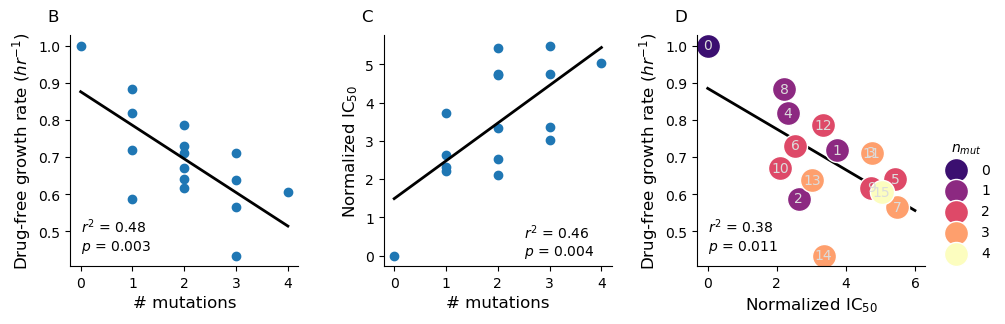

In [87]:
fig,ax_list = plt.subplots(ncols=3,figsize=(10,3))

g_drugless = np.array(g_drugless)
g_norm = g_drugless/g_drugless[0]

ax = ax_list[0]

ax.plot(mut_list,g_norm,'o')

res = stats.linregress(mut_list,g_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax = ax_list[1]

ic50_norm = ic50_est - ic50_est[0]

ax.plot(mut_list,ic50_norm,'o')

res = stats.linregress(mut_list,ic50_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(2.5,0),fontsize=10)

ax = ax_list[2]

cmap = cm.get_cmap('magma',6)
cmap = cmap.colors

mut_v_gr = [[],[],[],[],[]]

ic50_norm = ic50_est - ic50_est[0]

for key in data.index:

    ic50 = ic50_norm[int(key)]
    g = g_norm[int(key)]

    # key_bin = int(key)

    num = mut_list[int(key)]

    mut_v_gr[num].append(g_drugless)

    ax.scatter(ic50,g,marker='o',s=300,facecolor=cmap[num+1],
                edgecolors='w',label=int(num))
    # ax4.annotate(key,(ic50-0.15,g_drugless-0.001),fontsize=12)
    ax.annotate(key,(ic50,g),fontsize=10,ha='center',va='center',color='gainsboro')
    

# ax.set_ylim(0.06,0.115)
# ax.set_xlim(-3,4)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.set_xlabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

handles, labels = ax.get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax.legend(unique_handles,unique_labels,loc = (1.05,0),frameon=False,
             fontsize=10,title='$n_{mut}$')

res = stats.linregress(ic50_norm,g_norm)

xfit = np.arange(0,7)
yfit = res.slope*xfit + res.intercept

ax.plot(xfit,yfit,color='k',linewidth=2,zorder=0)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

labels = ['B','C','D']

indx = 0
for ax in ax_list:
    pos = ax.get_position()
    pos.x0 = pos.x0 + 0.04*indx
    pos.x1 = pos.x1 + 0.04*indx
    ax.set_position(pos)

    ax.annotate(labels[indx],(-0.1,1.06),fontsize=12,xycoords='axes fraction')

    indx += 1

# fig.tight_layout()
fig.savefig('../figures/gr_vs_ic50_regression.pdf',bbox_inches='tight')

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_35117/777457191.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


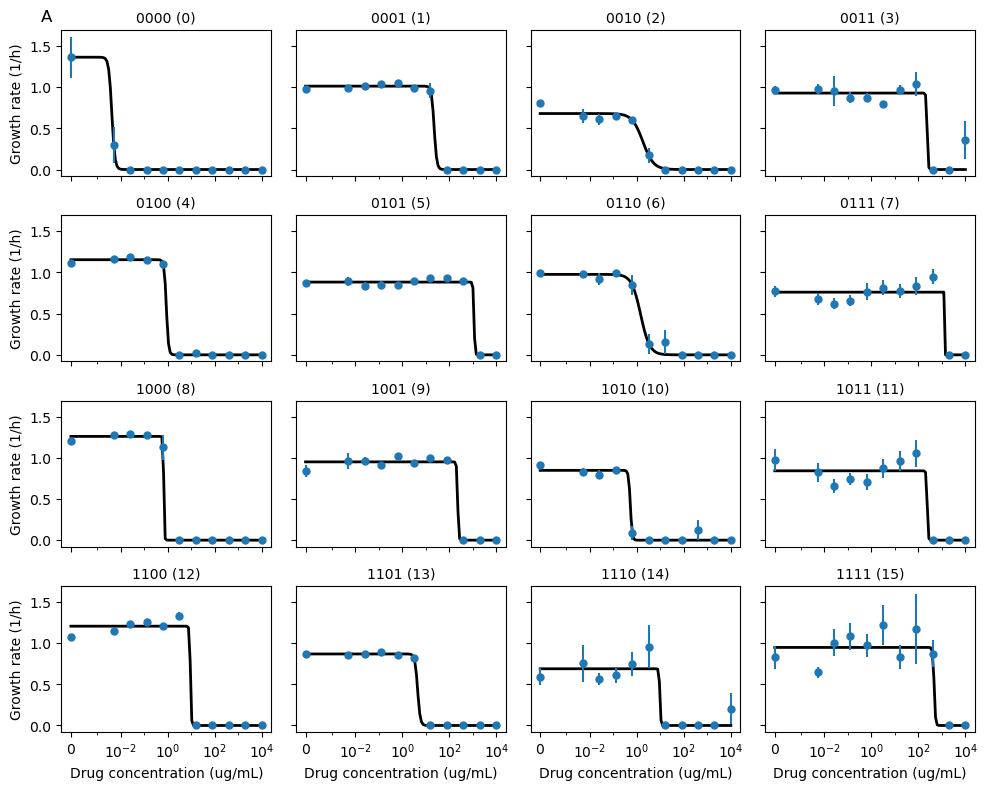

In [88]:
def hill_fn(conc,gmax, hc, ic_50):
    y = []
    gmin = 0
    for c in conc:
        if c == 0:
            y.append(gmax)
        else:
            y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))
    return y

fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(10,8),sharex=True,sharey=True)
ax_list_matrix = ax_list
ax_list = ax_list.flatten()

g_drugless = np.zeros(16)

mic_est = []

seascape_lib = {}

# drug_conc = np.array(gr_lib['drug_conc'])
drug_conc = list(gr_lib['drug_conc'])
drug_conc = [float(i) for i in drug_conc if i != 'control']

for key in np.arange(16):
    y = np.array(gr_lib[str(key)])
    y = y[0:-1]
    x = np.argwhere(y<0.5)
    mic = drug_conc[x[-1][0]]
    mic_est.append(mic)

for i in range(16):
    
    gr_v_dc = np.array(gr_lib[str(i)])
    gr_v_dc_err = np.array(gr_err_lib[str(i)])

    ic50_est = np.log10(np.array(mic_est[i]).astype(float))

    p0 = [gr_v_dc[-2],-0.1,ic50_est]
    # bounds = [[gr_v_dc[-2]-0.1,-10,ic50_est-2],[gr_v_dc[-2]+0.1,0,ic50_est+2]]
    bounds = [[0,-10,ic50_est-2],[2,0,ic50_est+2]]

    gr_v_dc_err_t = np.array(gr_v_dc_err) + 1

    popt,pcov = sciopt.curve_fit(hill_fn,drug_conc,gr_v_dc[0:-1],
                                p0=p0,maxfev=100000,bounds=bounds,
                                sigma=gr_v_dc_err_t[0:-1],absolute_sigma=False)
    
    xfit = np.logspace(-3,4,100)
    xfit = np.concatenate(([0],xfit))

    yfit = hill_fn(xfit,*popt)

    ax = ax_list[i]
    ax.plot(xfit,yfit,color='k',linewidth=2)

    ax.errorbar(drug_conc,gr_v_dc[0:-1],yerr=gr_v_dc_err[0:-1],
                fmt='o',markersize=5)
    
    ax.set_xscale('symlog',linthresh=10**-3)
    ax.set_title(int_to_binary(i) + ' (' + str(i) + ')',fontsize=10)
    # ax.set_yscale('log')
    g_drugless[i] = gr_v_dc[-2]

    param_dict = {'gmax':popt[0],'hc':popt[1],'ic50':popt[2]}
    seascape_lib[i] = param_dict

ax = ax_list[-1]
ax.set_xticks([0,10**-2,1,10**2,10**4]);

for ax in ax_list_matrix[-1,:]:
    ax.set_xlabel('Drug concentration (ug/mL)')

for ax in ax_list_matrix[:,0]:
    ax.set_ylabel('Growth rate (1/h)')

ax_list_matrix[0,0].annotate('A',(-0.1,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

fig.savefig('../figures/dose_response_curves.pdf',bbox_inches='tight')